In [1]:
import os
import numpy as np
import pandas as pd

# tej_key
tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(start = '2018-05-01', 
                    end = '2019-05-01',
                    mkt = ['TWSE', 'OTC'],
                    stktp_e=['Common Stock-Foreign', 'Common Stock']
                   )
len(pool)

Currently used TEJ API key call quota 1242/100000 (1.24%)
Currently used TEJ API key data quota 21267104/10000000 (212.67%)


1721

In [3]:
import TejToolAPI

df_MSCI = TejToolAPI.get_history_data(start = '2018-05-01',
                                      end = '2019-05-01',
                                      ticker = pool,
                                      columns = ['Component_Stock_of_MSCI_TW_Fg'],
                                      transfer_to_chinese = False)

df_MSCI

Currently used TEJ API key call quota 1329/100000 (1.33%)
Currently used TEJ API key data quota 22549654/10000000 (225.5%)


,coid,mdate,Component_Stock_of_MSCI_TW_Fg
0,1101,2018-05-02,Y
1,1102,2018-05-02,Y
2,1103,2018-05-02,
3,1104,2018-05-02,
4,1108,2018-05-02,
...,...,...,...
412186,9951,2019-04-30,
412187,9955,2019-04-30,
412188,9958,2019-04-30,
412189,9960,2019-04-30,


In [4]:
df_MSCI = df_MSCI.drop_duplicates(subset=['coid'])
df_filtered = df_MSCI[df_MSCI['Component_Stock_of_MSCI_TW_Fg'] == 'Y']
MSCI_pool = df_filtered['coid'].to_list()  # MSCI stocks 
len(MSCI_pool)

89

In [5]:
start = '2019-05-02'
end = '2024-05-01'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(MSCI_pool) + ' ' + 'IR0001'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 1357/100000 (1.36%)
Currently used TEJ API key data quota 23163392/10000000 (231.63%)


[2024-05-21 06:29:12.924154] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-05-21 06:29:26.652591] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [6]:
import TejToolAPI

columns = ['Transfer_Method_English', 'Transfer_Start_Date', 'Transfer_End_Date']
data = TejToolAPI.get_history_data(start = start, 
                                   end = end,
                                   ticker = MSCI_pool, 
                                   columns = columns,
                                   transfer_to_chinese = False
                                   )
data = data.sort_values(['coid','mdate'])
data

Currently used TEJ API key call quota 1365/100000 (1.36%)
Currently used TEJ API key data quota 23236743/10000000 (232.37%)


,coid,mdate,Transfer_Start_Date,Transfer_End_Date,Transfer_Method_English
0,1101,2019-05-02,2019-03-07,2019-04-06,Trade
50,1101,2019-05-03,2019-03-07,2019-04-06,Trade
100,1101,2019-05-06,2019-03-07,2019-04-06,Trade
150,1101,2019-05-07,2019-03-07,2019-04-06,Trade
200,1101,2019-05-08,2019-03-07,2019-04-06,Trade
...,...,...,...,...,...
107600,9945,2024-04-24,NaT,NaT,NaN
107638,9945,2024-04-25,NaT,NaT,NaN
107676,9945,2024-04-26,NaT,NaT,NaN
107714,9945,2024-04-29,NaT,NaT,NaN


In [7]:
tran_key = ['Trade', 'Great each a transaction trade', 'Trade/Fix the price after the plate']
tran_data = data[data['Transfer_Method_English'].isin(tran_key)]
tran_data['transfer'] = False
tran_data.loc[tran_data['Transfer_Start_Date'].shift(1) != tran_data['Transfer_Start_Date'], 'transfer'] = True
    
data_all = pd.merge(data, tran_data[['coid', 'mdate', 'transfer']], on = ['coid', 'mdate'], how = 'left')
data_all['transfer'] = data_all['transfer'].fillna(False)
data_all

,coid,mdate,Transfer_Start_Date,Transfer_End_Date,Transfer_Method_English,transfer
0,1101,2019-05-02,2019-03-07,2019-04-06,Trade,True
1,1101,2019-05-03,2019-03-07,2019-04-06,Trade,False
2,1101,2019-05-06,2019-03-07,2019-04-06,Trade,False
3,1101,2019-05-07,2019-03-07,2019-04-06,Trade,False
4,1101,2019-05-08,2019-03-07,2019-04-06,Trade,False
...,...,...,...,...,...,...
107748,9945,2024-04-24,NaT,NaT,NaN,False
107749,9945,2024-04-25,NaT,NaT,NaN,False
107750,9945,2024-04-26,NaT,NaT,NaN,False
107751,9945,2024-04-29,NaT,NaT,NaN,False


In [8]:
from zipline.data import bundles

bundle_name = 'tquant'
bundle = bundles.load(bundle_name)

In [9]:
from zipline.pipeline.data.dataset import Column, DataSet
from zipline.pipeline.domain import TW_EQUITIES

class CustomDataset(DataSet):
    
    Transfer_Method_English = Column(object)
    transfer = Column(bool)

    domain = TW_EQUITIES

In [10]:
sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbol_mapping_sid = {i.symbol:i.sid for i in assets}

In [11]:
transform_data = data_all.set_index(['coid', 'mdate']).unstack('coid')
transform_data = transform_data.rename(columns = symbol_mapping_sid)
transform_data.index = transform_data.index.tz_localize('UTC')
transform_data

Transfer_Start_Date                        \
coid                                       0          1          2    
mdate                                                                 
2019-05-02 00:00:00+00:00          2019-03-07        NaT 2018-12-25   
2019-05-03 00:00:00+00:00          2019-03-07        NaT 2018-12-25   
2019-05-06 00:00:00+00:00          2019-03-07        NaT 2018-12-25   
2019-05-07 00:00:00+00:00          2019-03-07        NaT 2018-12-25   
2019-05-08 00:00:00+00:00          2019-03-07        NaT 2018-12-25   
...                                       ...        ...        ...   
2024-04-24 00:00:00+00:00          2023-05-19 2020-12-08 2018-12-25   
2024-04-25 00:00:00+00:00          2023-05-19 2020-12-08 2018-12-25   
2024-04-26 00:00:00+00:00          2023-05-19 2020-12-08 2018-12-25   
2024-04-29 00:00:00+00:00          2023-05-19 2020-12-08 2018-12-25   
2024-04-30 00:00:00+00:00          2023-05-19 2020-12-08 2018-12-25   

                                                                       \
coid                              3          4          5          6    
mdate                                                                   
2019-05-02 00:00:00+00:00        NaT        NaT        NaT        NaT   
2019-05-03 00:00:00+00:00        NaT        NaT        NaT        NaT   
2019-05-06 00:00:00+00:00        NaT        NaT        NaT        NaT   
2019-05-07 00:00:00+00:00        NaT        NaT        NaT        NaT   
2019-05-08 00:00:00+00:00        NaT        NaT        NaT        NaT   
...                              ...        ...        ...        ...   
2024-04-24 00:00:00+00:00 2022-05-26 2024-04-01 2024-02-26 2024-02-26   
2024-04-25 00:00:00+00:00 2022-05-26 2024-04-01 2024-02-26 2024-02-26   
2024-04-26 00:00:00+00:00 2022-05-26 2024-04-01 2024-02-26 2024-02-26   
2024-04-29 00:00:00+00:00 2022-05-26 2024-04-01 2024-02-26 2024-02-26   
2024-04-30 00:00:00+00:00 2022-05-26 2024-04-01 2024-02-26 2024-02-26   

                                                     ... transfer         \
coid                              7          8   9   ...       79     80   
mdate                                                ...                   
2019-05-02 00:00:00+00:00        NaT        NaT NaT  ...    False  False   
2019-05-03 00:00:00+00:00        NaT        NaT NaT  ...    False  False   
2019-05-06 00:00:00+00:00        NaT        NaT NaT  ...    False  False   
2019-05-07 00:00:00+00:00        NaT        NaT NaT  ...    False  False   
2019-05-08 00:00:00+00:00        NaT        NaT NaT  ...    False  False   
...                              ...        ...  ..  ...      ...    ...   
2024-04-24 00:00:00+00:00 2023-03-28 2023-01-01 NaT  ...    False  False   
2024-04-25 00:00:00+00:00 2023-03-28 2023-01-01 NaT  ...    False  False   
2024-04-26 00:00:00+00:00 2023-03-28 2023-01-01 NaT  ...    False  False   
2024-04-29 00:00:00+00:00 2023-03-28 2023-01-01 NaT  ...    False  False   
2024-04-30 00:00:00+00:00 2023-03-28 2023-01-01 NaT  ...    False  False   

                                                                            \
coid                          81     82     83     84     85     86     87   
mdate                                                                        
2019-05-02 00:00:00+00:00  False  False  False  False  False  False  False   
2019-05-03 00:00:00+00:00  False  False  False  False  False  False  False   
2019-05-06 00:00:00+00:00  False  False  False  False  False  False  False   
2019-05-07 00:00:00+00:00  False  False  False  False  False  False  False   
2019-05-08 00:00:00+00:00  False  False  False  False  False  False  False   
...                          ...    ...    ...    ...    ...    ...    ...   
2024-04-24 00:00:00+00:00  False  False  False  False  False  False  False   
2024-04-25 00:00:00+00:00  False  False  False  False  False  False  False   
2024-04-26 00:00:00+00:00  False  False  False  False  False  False  False   
2024-04

In [12]:
from zipline.pipeline.loaders.frame import DataFrameLoader

custom_loader = {}

inputs=[
        CustomDataset.Transfer_Method_English,
        CustomDataset.transfer
        ]

for i in inputs:
    custom_loader[i]=DataFrameLoader(column=i,
                                     baseline=transform_data[i.name])
custom_loader

{CustomDataset<TW>.Transfer_Method_English::object: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x125f1588430>,
 CustomDataset<TW>.transfer::bool: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x125f158a860>}

In [13]:
from zipline.pipeline import SimplePipelineEngine
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.loaders import EquityPricingLoader
pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader,
                                                bundle.adjustment_reader)
def choose_loader(column):
    if column.name in TWEquityPricing._column_names:
        return pricing_loader
    elif column.name in CustomDataset._column_names:     
        return custom_loader[column]
    else:
        raise Exception('Column not available')
    
engine = SimplePipelineEngine(get_loader = choose_loader,
                              asset_finder = bundle.asset_finder,
                              default_domain = TW_EQUITIES)

In [14]:
from zipline.pipeline import Pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.factors import RSI, ExponentialWeightedMovingAverage

benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():
    
    return Pipeline(
        columns = {
            'price': TWEquityPricing.close.latest,
            'RSI': RSI(inputs = [TWEquityPricing.close], window_length = 14),
            'Transfer_Method_English': CustomDataset.Transfer_Method_English.latest,
            'transfer': CustomDataset.transfer.latest
                },
            screen = ~StaticAssets([benchmark_asset])
    )

start_dt = pd.Timestamp(start, tz = 'UTC')
end_dt = pd.Timestamp(end, tz = 'UTC')
        
pipeline_result = engine.run_pipeline(make_pipeline(), start_dt, end_dt)
pipeline_result 

price        RSI  \
2019-05-03 00:00:00+00:00 Equity(0 [1101])    42.20        NaN   
                          Equity(1 [1102])    42.05        NaN   
                          Equity(2 [1216])    73.70        NaN   
                          Equity(3 [1227])    54.10        NaN   
                          Equity(4 [1301])   112.00        NaN   
...                                             ...        ...   
2024-04-30 00:00:00+00:00 Equity(84 [8464])  378.00  78.160920   
                          Equity(85 [9904])   36.30  53.378378   
                          Equity(86 [9910])  164.00  56.603774   
                          Equity(87 [9921])  228.00  65.079365   
                          Equity(88 [9945])   38.75  80.000000   

                                            Transfer_Method_English  transfer  
2019-05-03 00:00:00+00:00 Equity(0 [1101])                    Trade     False  
                          Equity(1 [1102])                              False  
                          Equity(2 [1216])                     Gift     False  
                          Equity(3 [1227])                              False  
                          Equity(4 [1301])                              False  
...                                                             ...       ...  
2024-04-30 00:00:00+00:00 Equity(84 [8464])                   Trust     False  
                          Equity(85 [9904])                    Gift     False  
                          Equity(86 [9910])                    Gift     False  
                          Equity(87 [9921])                    Gift     False  
                          Equity(88 [9945])                             False  

[107664 rows x 4 columns]

In [15]:
from zipline.finance import slippage, commission
from zipline.utils.calendar_utils import get_calendar
from logbook import Logger, StderrHandler, INFO
from zipline.api import *

# Set up 'log' so we can see trading details when backtesting.
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))
    set_long_only(on_error = 'fail')
    attach_pipeline(make_pipeline(), 'mystrategy')

In [16]:
def handle_data(context, data):
        
    out_dir = pipeline_output('mystrategy')

    for i in out_dir.index: 
        sym = i.symbol
        price = out_dir.loc[i, 'price']
        rsi = out_dir.loc[i, 'RSI']
        transfer = out_dir.loc[i, 'transfer']
        tran_method = out_dir.loc[i, 'Transfer_Method_English']

        if (tran_method == '') and (transfer == True) :
            continue
        
        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount

        buy, sell = False, False
        
        record(
           **{
                f'price_{sym}': price,
                f'transfer_{sym}': transfer,
                f'buy_{sym}': buy,
                f'sell_{sym}': sell 
            }
        )

        # Buy when there is no position, transfer occurs and there is enough cash. 
        if stock_position == 0:
            if (transfer == True) and (cash_position > 15000):
                order_value(i, 15000)
                buy = True
                record(**{f'buy_{sym}': buy})
        
        # When there are short positions, cancel the order.
        # This is to prevent the unexpected occurrence of short positions.
        elif stock_position < 0:
            open_orders = get_open_orders()
            
            for asset in open_orders:
                for o in open_orders[asset]:
                    cancel_order(o)
        
        elif stock_position > 0:
            # overweight if another transfer occur
            if (transfer == True) and (cash_position > 15000):
                order_value(i, 15000)
                buy = True
                record(**{f'buy_{sym}': buy})
        
            # sell half of our holding positions when rsi > 95
            elif rsi > 95:
                order(i, -0.5 * stock_position)
                sell = True
                record(**{f'sell_{sym}': sell})

In [17]:
def analyze(context, perf):
    pass

In [18]:
from zipline import run_algorithm
results = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize = initialize,
    bundle = 'tquant',
    analyze = analyze,
    capital_base = 1e6,
    handle_data = handle_data,
    custom_loader = custom_loader
)

[2024-05-21 06:29:35.974573]: INFO: earn_dividends: Equity(35 [2408]), cash_dividend amount: 7.1104997, pay_date: 2019-07-26, div_owed: 113.7679952
[2024-05-21 06:29:36.067165]: INFO: earn_dividends: Equity(17 [2303]), cash_dividend amount: 0.5898939599999999, pay_date: 2019-08-06, div_owed: 1310.7443791199998
[2024-05-21 06:29:36.123801]: INFO: earn_dividends: Equity(14 [2105]), cash_dividend amount: 1.1, pay_date: 2019-08-23, div_owed: 418.00000000000006
[2024-05-21 06:29:36.125803]: INFO: earn_dividends: Equity(16 [2301]), cash_dividend amount: 2.92, pay_date: 2019-08-21, div_owed: 972.36
[2024-05-21 06:29:36.126798]: INFO: earn_dividends: Equity(67 [3231]), cash_dividend amount: 1.4879328299999999, pay_date: 2019-08-14, div_owed: 970.1322051599999
[2024-05-21 06:29:36.319012]: INFO: earn_dividends: Equity(78 [5880]), cash_dividend amount: 0.75, pay_date: 2019-09-18, div_owed: 535.5
[2024-05-21 06:29:36.320973]: INFO: handle_split: after split: asset: Equity(78 [5880]), amount: 735,

In [19]:
results

,period_open,period_close,pnl,treasury_return,orders,returns,benchmark_return,longs_count,shorts_count,ending_cash,...,buy_9910,sell_9910,price_9921,transfer_9921,buy_9921,sell_9921,price_9945,transfer_9945,buy_9945,sell_9945
2019-05-02 13:30:00+08:00,2019-05-02 09:01:00+08:00,2019-05-02 13:30:00+08:00,0.000000,0.0,[],0.000000,NaN,0,0,1000000.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-03 13:30:00+08:00,2019-05-03 09:01:00+08:00,2019-05-03 13:30:00+08:00,0.000000,0.0,"[{'id': 'f973d8f566fb4556bfbf08085259fd0b', 'd...",0.000000,0.008344,0,0,1000000.000000,...,False,False,231.0,False,False,False,42.30,False,False,False
2019-05-06 13:30:00+08:00,2019-05-06 09:01:00+08:00,2019-05-06 13:30:00+08:00,-21.000008,0.0,"[{'id': 'f973d8f566fb4556bfbf08085259fd0b', 'd...",-0.000021,-0.017950,1,0,985286.299992,...,False,False,230.5,False,False,False,42.45,False,False,False
2019-05-07 13:30:00+08:00,2019-05-07 09:01:00+08:00,2019-05-07 13:30:00+08:00,-132.250001,0.0,"[{'id': '4155abfeeeb64a3b929cf89350f497bf', 'd...",-0.000132,0.008261,1,0,992525.299991,...,False,False,224.0,False,False,False,41.60,False,False,False
2019-05-08 13:30:00+08:00,2019-05-08 09:01:00+08:00,2019-05-08 13:30:00+08:00,-27.150000,0.0,[],-0.000027,-0.005769,1,0,992525.299991,...,False,False,225.0,False,False,False,41.65,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24 13:30:00+08:00,2024-04-24 09:01:00+08:00,2024-04-24 13:30:00+08:00,42023.750000,0.0,[],0.018382,0.027167,40,0,53025.177386,...,False,False,221.5,False,False,False,36.95,False,False,False
2024-04-25 13:30:00+08:00,2024-04-25 09:01:00+08:00,2024-04-25 13:30:00+08:00,-27556.400000,0.0,[],-0.011791,-0.013594,40,0,53130.431456,...,False,False,226.0,False,False,False,36.85,False,False,False
2024-04-26 13:30:00+08:00,2024-04-26 09:01:00+08:00,2024-04-26 13:30:00+08:00,19277.800000,0.0,[],0.008480,0.013249,40,0,53362.031456,...,False,False,222.5,False,False,False,36.85,False,False,False
2024-04-29 13:30:00+08:00,2024-04-29 09:01:00+08:00,2024-04-29 13:30:00+08:00,44681.100000,0.0,[],0.019257,0.018638,40,0,53362.031456,...,False,False,222.5,False,False,False,37.90,False,False,False


<AxesSubplot:>

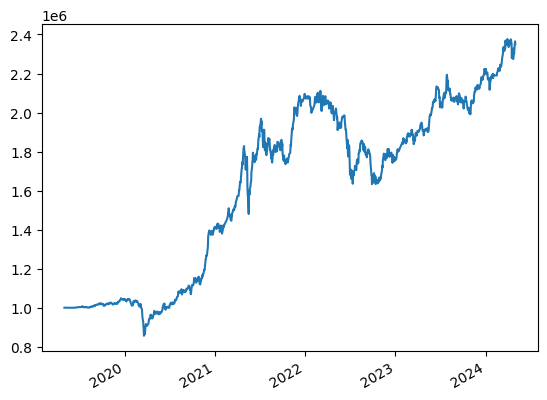

In [20]:
results.portfolio_value.plot()

Start date,2019-05-02
End date,2024-04-30
Total months,58
,Backtest
Annual return,19.348%
Cumulative returns,135.115%
Annual volatility,15.449%
Sharpe ratio,1.22
Calmar ratio,0.85
Stability,0.82
Max drawdown,-22.649%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.65,2022-03-03,2022-09-28,2023-06-15,315
1,19.03,2021-04-28,2021-05-17,2021-06-24,40
2,18.31,2019-12-17,2020-03-19,2020-07-30,149
3,11.82,2021-07-06,2021-10-13,2021-11-16,93
4,9.23,2023-07-28,2023-10-31,2023-12-26,104


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.07%,-5.82%,6.79%


Top 10 long positions of all time,max
sid,
2303,31.27%
2883,22.69%
2603,20.44%
2610,12.49%
2884,11.41%
2409,10.98%
2618,9.29%
2891,9.20%
1504,8.98%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2303,31.27%
2883,22.69%
2603,20.44%
2610,12.49%
2884,11.41%
2409,10.98%
2618,9.29%
2891,9.20%
1504,8.98%


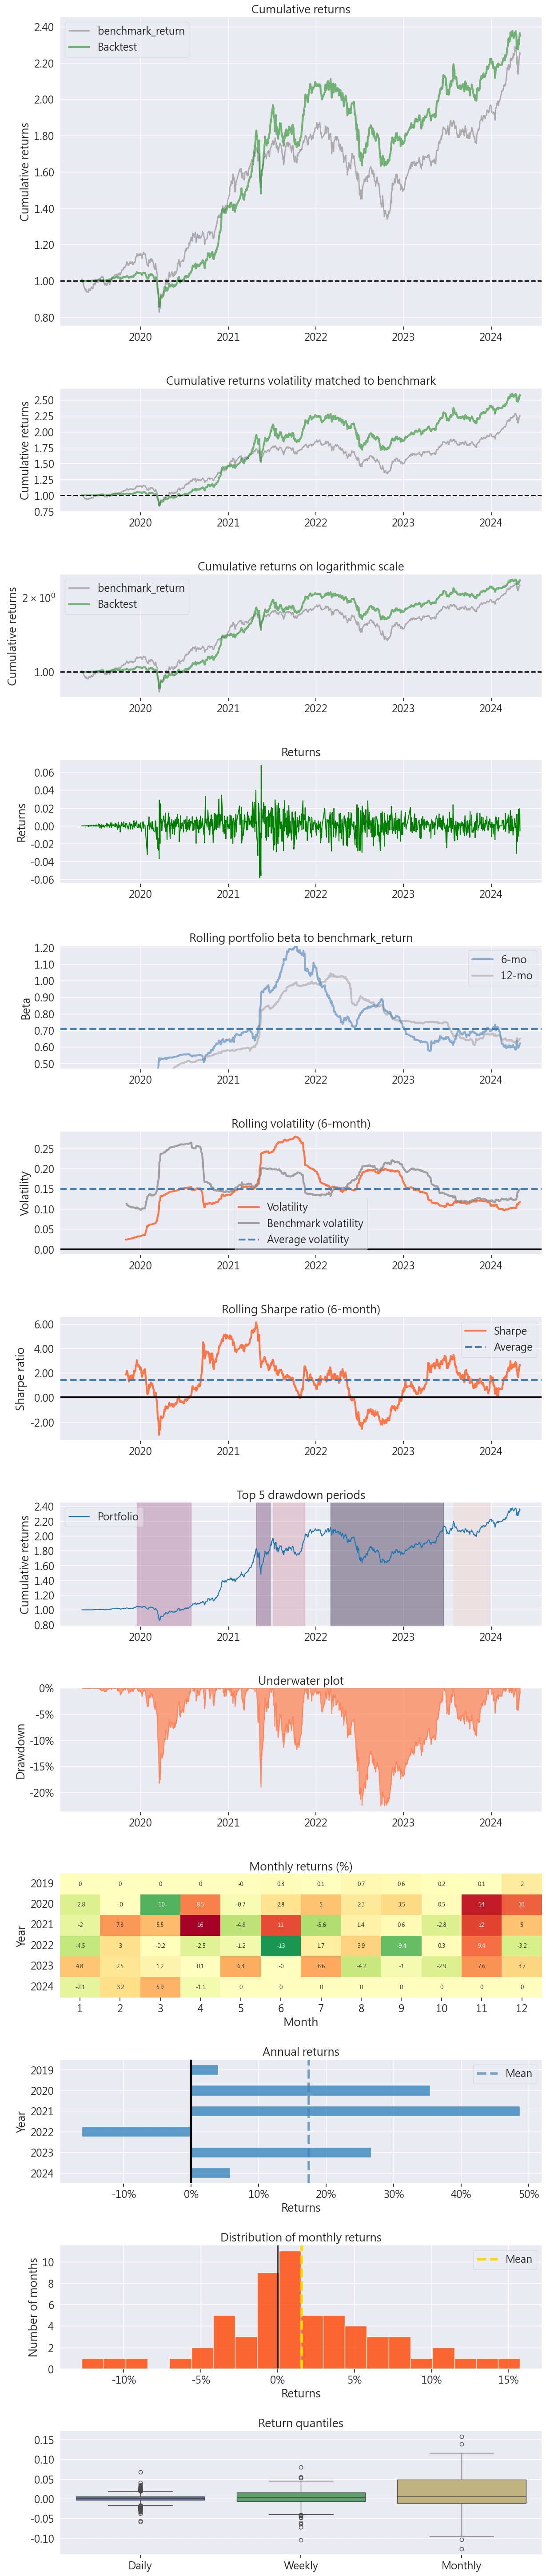

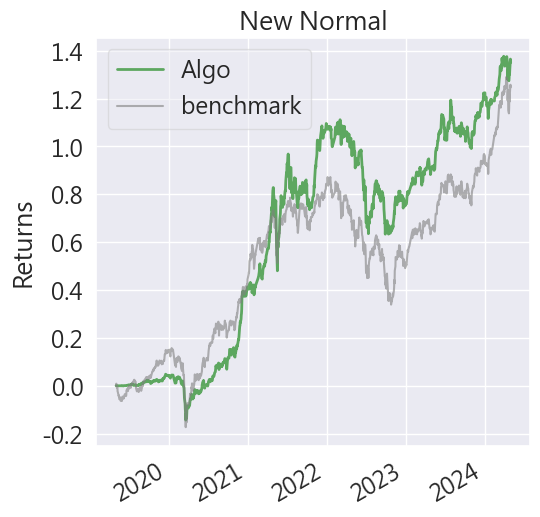

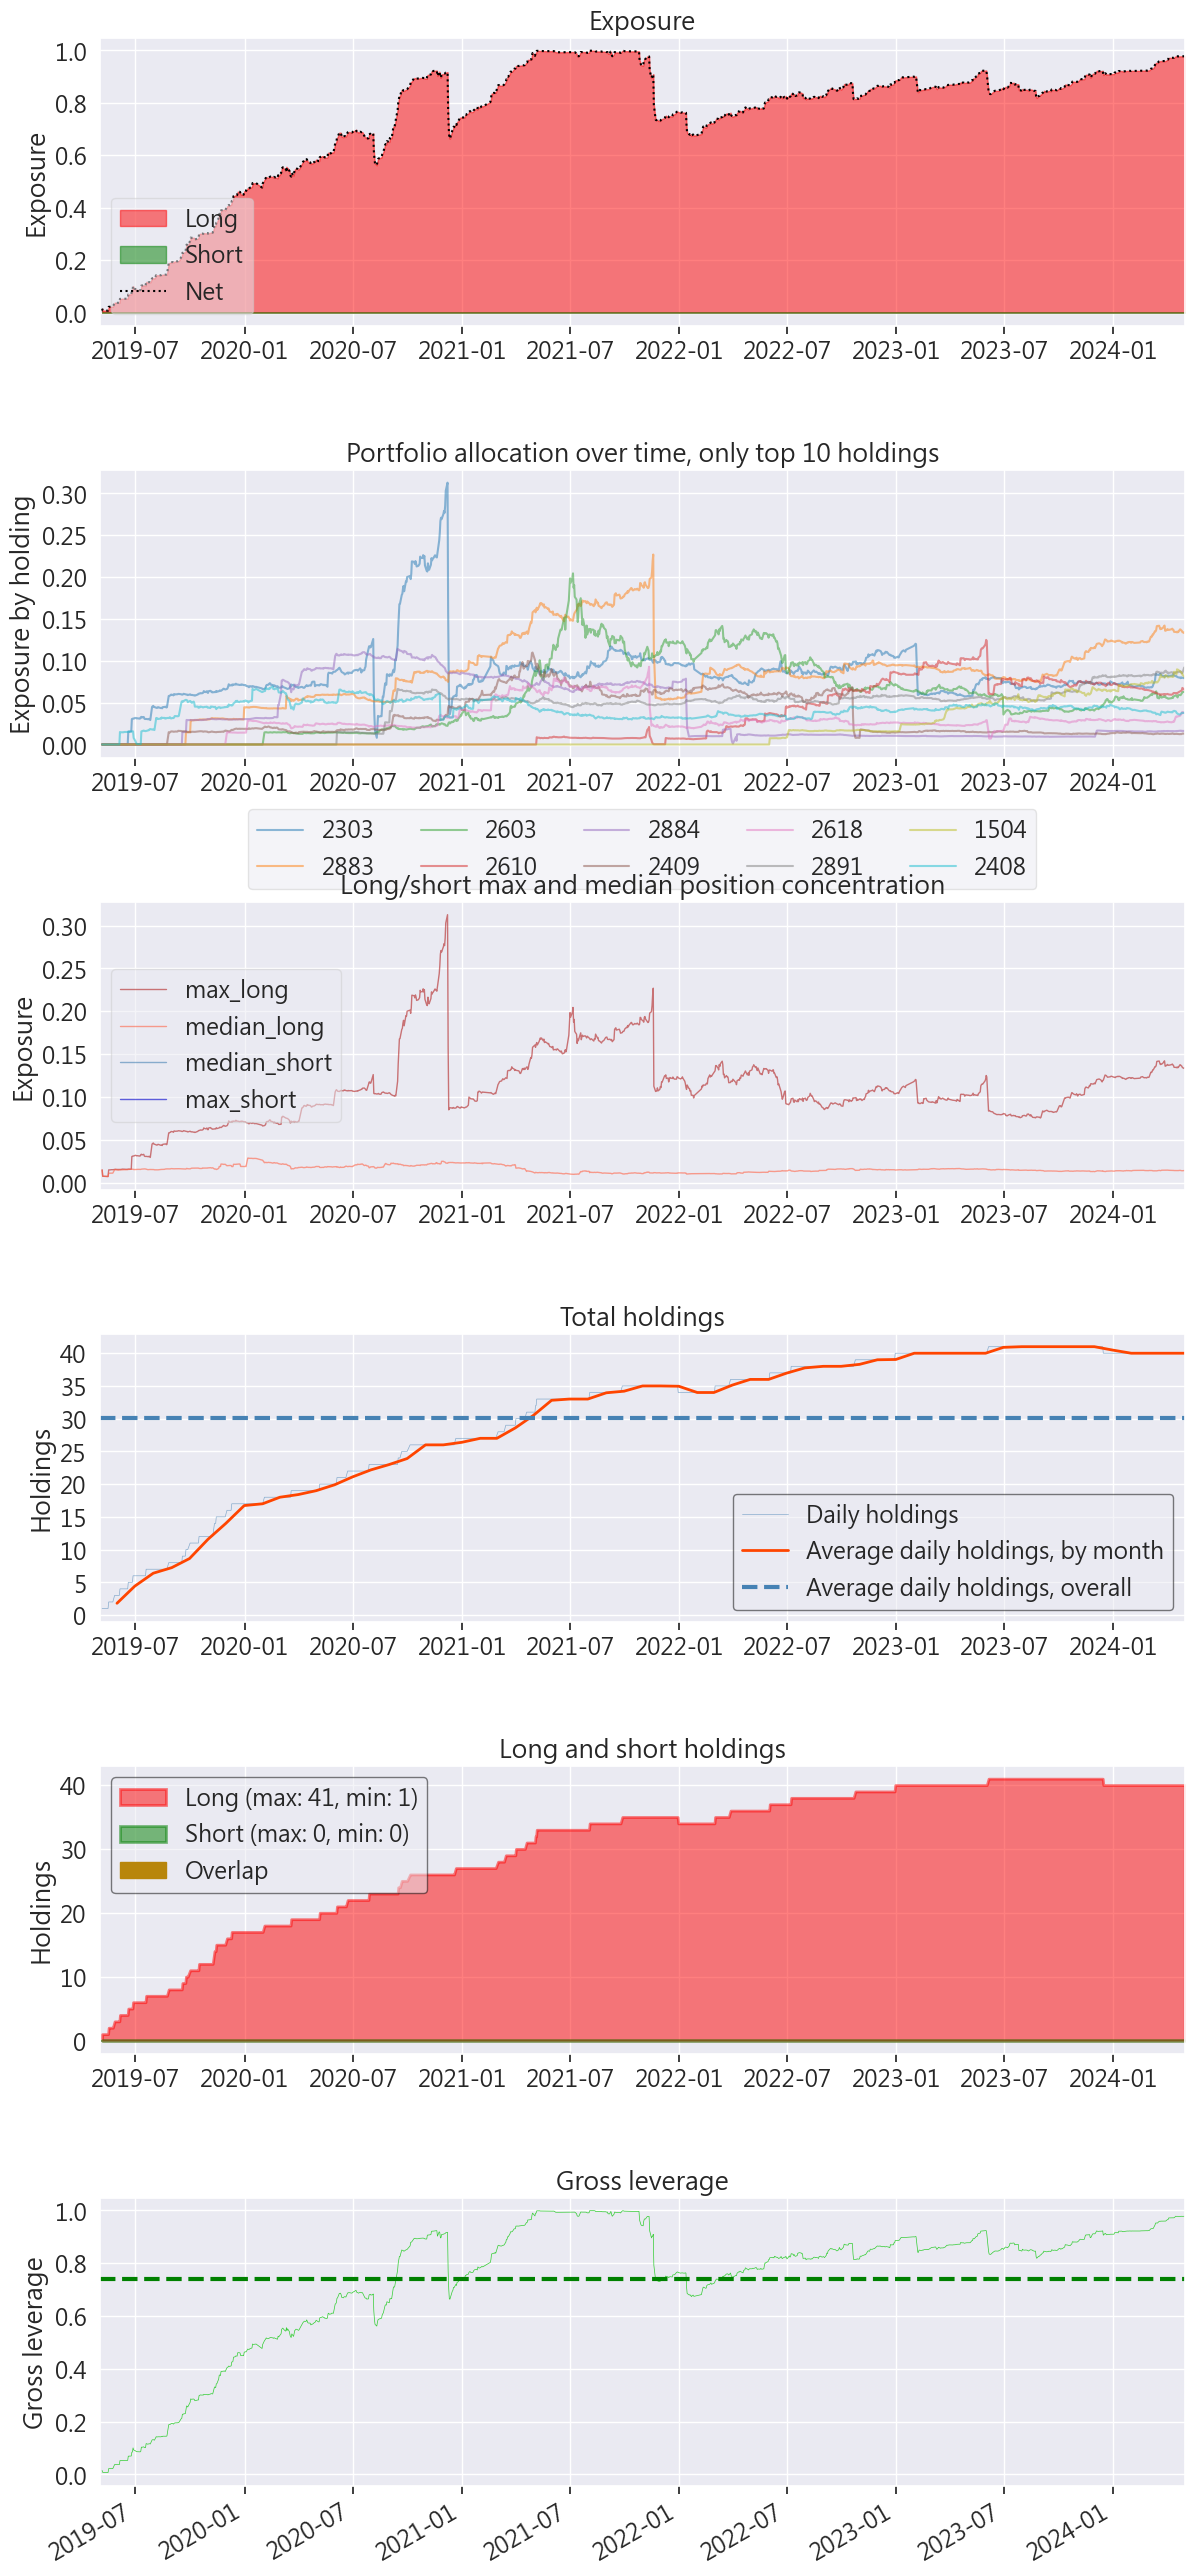

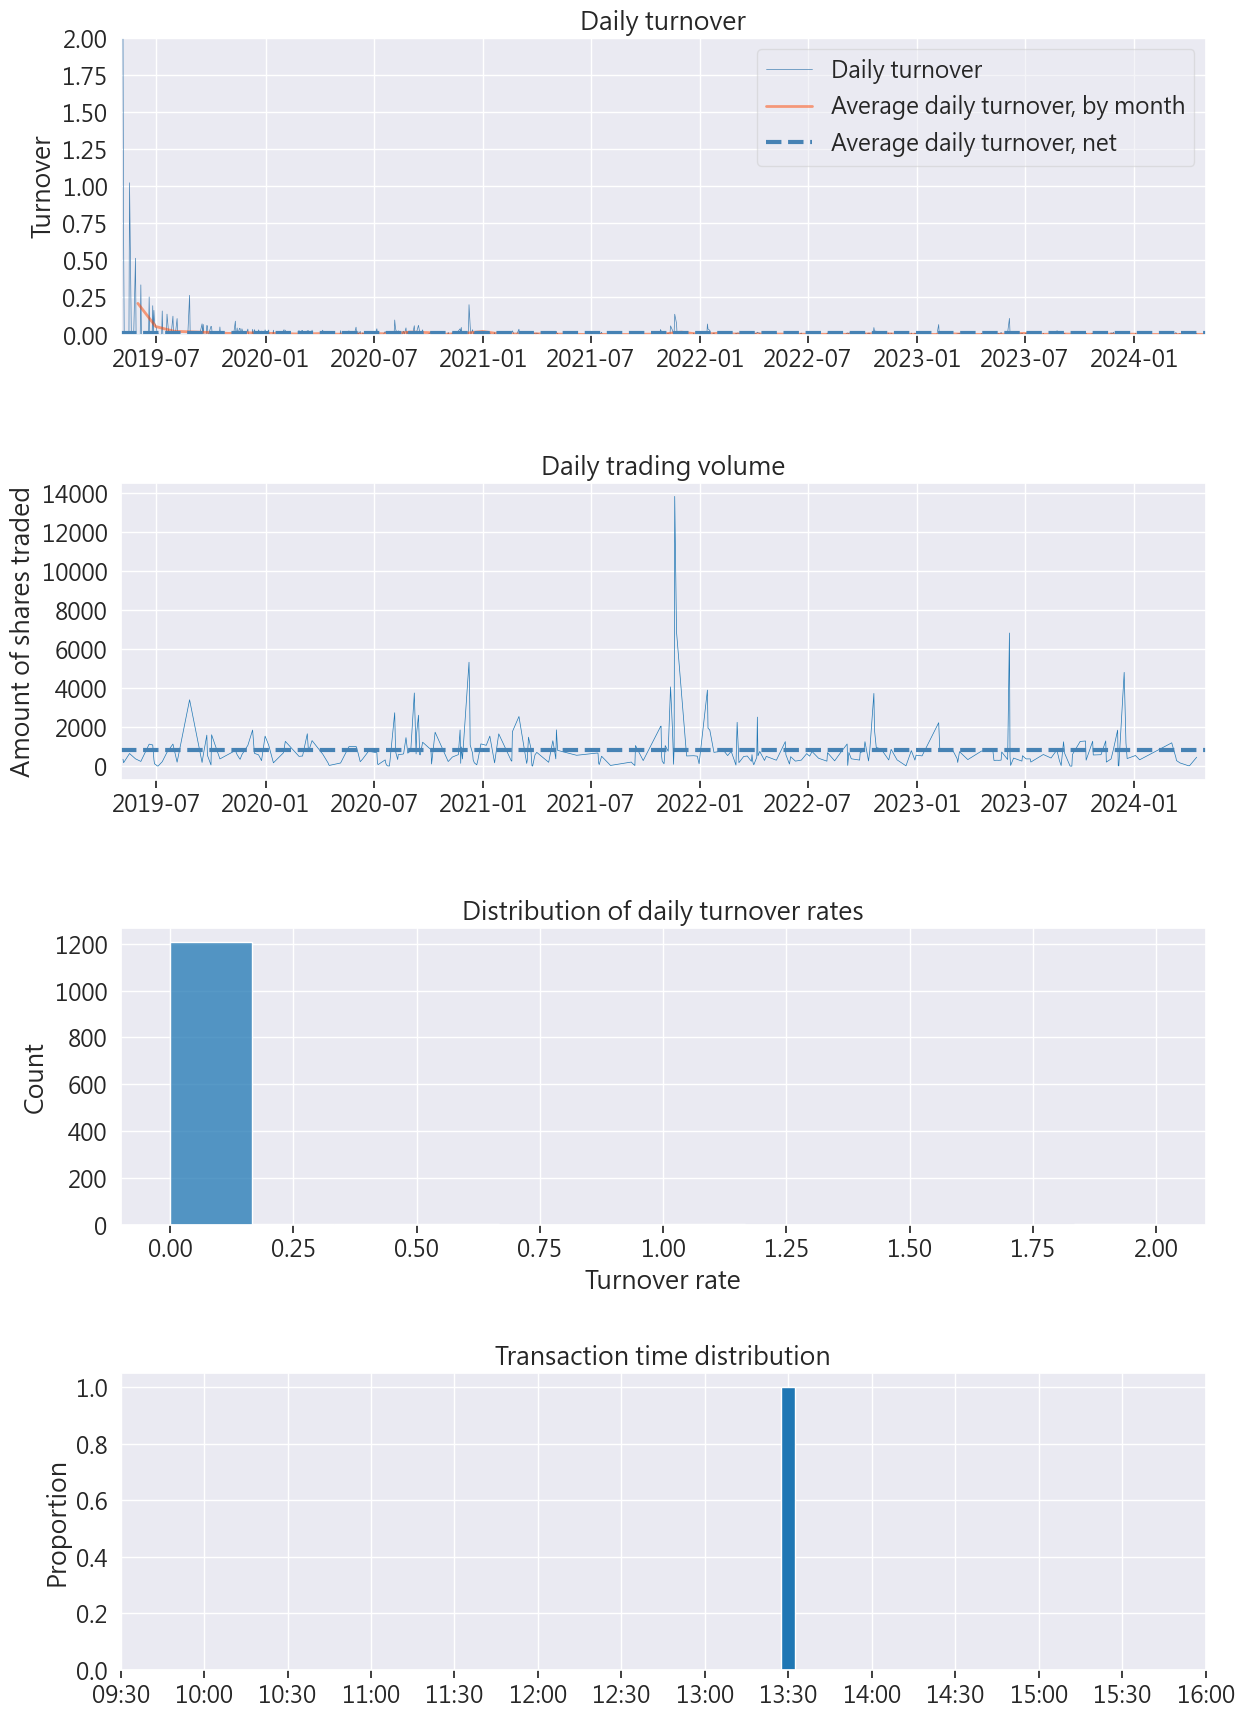

In [21]:
import pyfolio as pf

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns=returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark_rets
                         )